In [118]:
from utils.consts import * ## const variables are there, so paths and extraction features ##
from utils. plotting import * ## plotting ##
from data_reader_babalit import * ## the class which reads balabit dataset ##
from data_reader_chaoshen import * ## the class which reads chaoshen datasets TODO There are several issues with this dataset -> explained later ##
from legality_analyser import * ## the class which analyses the datasets with 0 1 labels --> splitting samples is being done there ##  
import random
from nonlegality_analyser import * ## the class which analyses the datasets without 0 1 labels --> splitting samples is being done there ##  


from custom_dataset import *
from VAEmodel import *


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

from torch.utils.data import  DataLoader
from torchvision import transforms
from neural_data_creator import *




## Creating dataset

In [119]:

## Specyfing the USERS ## 
users = [7,9,12,15,16,20,21,23,29, 35]
## Creating the object which analyses the dataset ## 
balabit_reader = DataReaderBalabit(BALABIT, users, False) ## the arguments are DATASET, users, supervised, how many records should be procesed ##
balabit_reader.processDataWithoutLabels() ## creating the data without labels ##
## getting path from the reader ##
path = balabit_reader.getFileName()

## creating analyser class ## 
balabitAnalyser = nonLegalityAnalyser(path)
## counting how many actions were extracted ## 
print(balabitAnalyser.countActions())



File already exist
type_of_action     1     3     4
userid                          
7               3885  4090   695
9               2473  2580   288
12              8350  4561   874
15              3332  4796   639
16              5231  6681  1450
20              3297  2723   333
21              3383  3161   528
23              2519  3927   307
29              2683  4871   938
35              2927  2401   380


Dataset Variables

In [120]:
test_ratio = 0.2
threshold_ratio = 0.1
trueUser = 9
dataset = balabitAnalyser.createTrainingDataWithLabel(trueUser)
neuralDataCreator = NeuralDataCreator(dataset)
x_training, y_training, x_validation, y_validation, x_threshold_positive, x_threshold_negative, y_threshold, x_test, y_test = neuralDataCreator.create_data(test_ratio, threshold_ratio)

In [121]:
training_dataset, validation_dataset, treshold_dataset_positive, treshold_dataset_negative , test_dataset = neuralDataCreator.create_datasets(x_training, x_validation , x_threshold_positive, x_threshold_negative, x_test)

In [122]:
input_size = 39  
hidden_size = 128
latent_size = 10
learning_rate = 1e-5
batch_size = 16

In [123]:
## CREATING DATALOADERS ##

training_loader = DataLoader(training_dataset, batch_size=16, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
threshold_loader_positive = DataLoader(treshold_dataset_positive, batch_size=batch_size, shuffle=False)
threshold_loader_negative = DataLoader(treshold_dataset_negative, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model || Learning loop

In [124]:
model = VAE(input_size, hidden_size, latent_size, learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

weight = 0.5

# Optimizer
num_epochs = 100
for epoch in range(num_epochs):
    for batch in training_loader:
        model.train()  # Set the model to training mode
        kl_weight = min(epoch / (num_epochs/3), 1.0)
        # kl_weight = 1

        x = batch.to(device)
        x = x.view(-1, input_size)

        # Forward pass
        loss = model.train_step(x, weight, kl_weight)

   
    # Validation phase
    model.eval()
    with torch.no_grad():
        total_validation_loss = 0.0
        num_validation_batches = 0

        for batch in validation_loader:
            x_val = batch.to(device)
            x_val = x_val.view(-1, input_size)
            reconstruction_val, mu_val, log_var_val = model(x_val)
            validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)

            total_validation_loss += validation_loss.item()
            num_validation_batches += 1

    average_validation_loss = total_validation_loss / num_validation_batches

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss:.4f}, Validation Loss: {average_validation_loss:.4f}')


Epoch [1/100], Training Loss: 120.7225, Validation Loss: 132.5485
Epoch [2/100], Training Loss: 94.8401, Validation Loss: 106.7781
Epoch [3/100], Training Loss: 78.6610, Validation Loss: 86.1774
Epoch [4/100], Training Loss: 58.2150, Validation Loss: 69.6102
Epoch [5/100], Training Loss: 44.4226, Validation Loss: 57.1687
Epoch [6/100], Training Loss: 36.3345, Validation Loss: 49.0015
Epoch [7/100], Training Loss: 28.4820, Validation Loss: 43.6686
Epoch [8/100], Training Loss: 32.3695, Validation Loss: 40.7338
Epoch [9/100], Training Loss: 27.8562, Validation Loss: 38.4268
Epoch [10/100], Training Loss: 25.5302, Validation Loss: 37.0512
Epoch [11/100], Training Loss: 27.7083, Validation Loss: 35.3313
Epoch [12/100], Training Loss: 25.3038, Validation Loss: 34.3135
Epoch [13/100], Training Loss: 24.1461, Validation Loss: 32.8357
Epoch [14/100], Training Loss: 22.7936, Validation Loss: 31.8032
Epoch [15/100], Training Loss: 22.2668, Validation Loss: 30.8943
Epoch [16/100], Training Loss: 

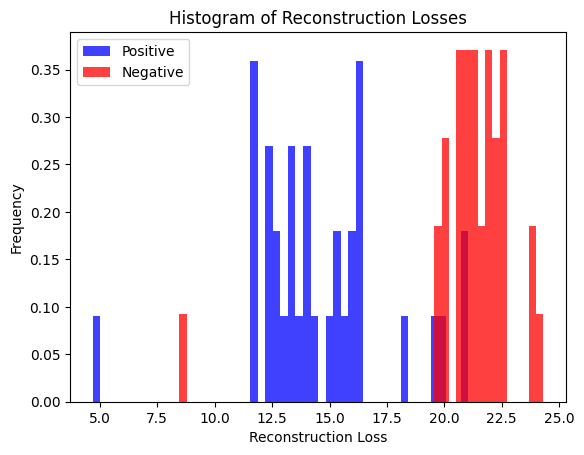

In [125]:
# Assuming you have separate DataLoader for negative test data (test_negative_loader)
reconstruction_losses_positive = []
reconstruction_losses_negative = []

model.eval()
with torch.no_grad():
    # Evaluate on positive test data
    for batch in threshold_loader_positive:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_reconstruction_loss(reconstruction_test, x_test)
        reconstruction_losses_positive.append(test_loss.item())
    # Evaluate on negative test data
    for batch in threshold_loader_negative:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_reconstruction_loss(reconstruction_test, x_test)
        reconstruction_losses_negative.append(test_loss.item())

# Plot histograms for both positive and negative test data
plt.hist(reconstruction_losses_positive, bins=50, density=True, alpha=0.75, color='blue', label='Positive')
plt.hist(reconstruction_losses_negative, bins=50, density=True, alpha=0.75, color='red', label='Negative')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.legend()
plt.show()

mean_positive = np.mean(reconstruction_losses_positive)
mean_negative = np.mean(reconstruction_losses_negative)

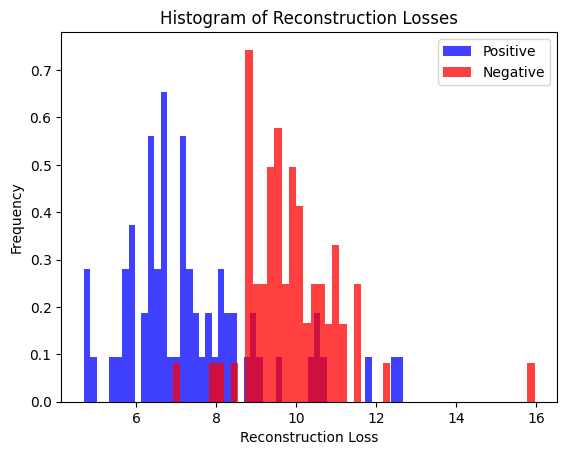

In [103]:
# Assuming you have separate DataLoader for negative test data (test_negative_loader)
reconstruction_losses_positive = []
reconstruction_losses_negative = []

model.eval()

with torch.no_grad():
    # Evaluate on positive test data
    for batch in threshold_loader_positive:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_loss(reconstruction_test, x_test, mu_test, log_var_test, weight, kl_weight)
        reconstruction_losses_positive.append(test_loss.item())

    # Evaluate on negative test data
    for batch in threshold_loader_negative:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_loss(reconstruction_test, x_test, mu_test, log_var_test, weight, kl_weight)
        reconstruction_losses_negative.append(test_loss.item())

# Plot histograms for both positive and negative test data
plt.hist(reconstruction_losses_positive, bins=50, density=True, alpha=0.75, color='blue', label='Positive')
plt.hist(reconstruction_losses_negative, bins=50, density=True, alpha=0.75, color='red', label='Negative')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.legend()
plt.show()

mean_positive = np.mean(reconstruction_losses_positive)
mean_negative = np.mean(reconstruction_losses_negative)

## THRESHOLD FINDING ##

In [104]:
model.eval()
artificial_labels  = []
validation_losses = []
reconstruction_losses_positive = []
reconstruction_losses_negative = []
with torch.no_grad():
    total_validation_loss = 0.0
    num_validation_batches = 0


 
    for batch in threshold_loader_negative:
            x_val = batch.to(device)
            x_val = x_val.view(-1, input_size)
            reconstruction_val, mu_val, log_var_val = model(x_val)
            validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
            validation_losses.append(validation_loss.item())
            total_validation_loss += validation_loss.item()
            num_validation_batches += 1
            artificial_labels.append(1)
            reconstruction_losses_negative.append(validation_loss.item())

    for batch in threshold_loader_positive:
        x_val = batch.to(device)
        x_val = x_val.view(-1, input_size)
        reconstruction_val, mu_val, log_var_val = model(x_val)
        validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
        validation_losses.append(validation_loss.item())
        total_validation_loss += validation_loss.item()
        num_validation_batches += 1
        artificial_labels.append(0)
        reconstruction_losses_positive.append(validation_loss.item())


    average_validation_loss = total_validation_loss / num_validation_batches

    num_samples = num_validation_batches



thresholds = np.linspace(min(validation_losses), max(validation_losses), 100)
f1_scores = [f1_score(artificial_labels, validation_losses > t) for t in thresholds]
# f1_scores = [f1_score(y_artificial_lab, validation_losses > t) for t in thresholds]

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f'F1-Score: {max(f1_scores):.4f}, Optimal Threshold: {optimal_threshold:.4f}')

F1-Score: 0.8933, Optimal Threshold: 7.8170


## ROC AUC CHECK

In [105]:
fpr, tpr, threshold = roc_curve(artificial_labels, validation_losses)


In [106]:
optimal_threshold_index_auc = np.argmax(tpr - fpr)

# Get the optimal threshold value
optimal_threshold_ROC = threshold[optimal_threshold_index_auc]
optimal_threshold_ROC

8.553742408752441

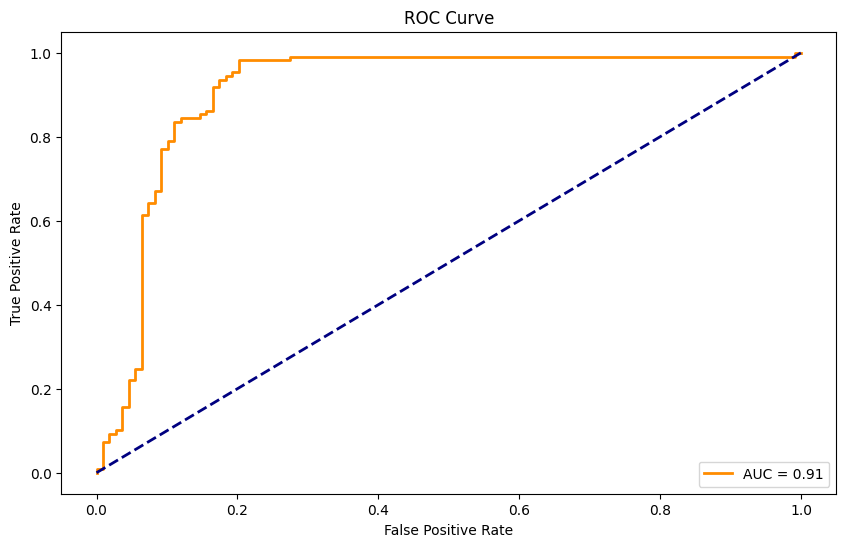

In [91]:
## USE OPTIMAL THRESHOLD TO CALCULATE ROC AUC ## 
predictions = (validation_losses < optimal_threshold).astype(int)

# Calculate the ROC curve
fpr, tpr, threshold = roc_curve(artificial_labels, validation_losses)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

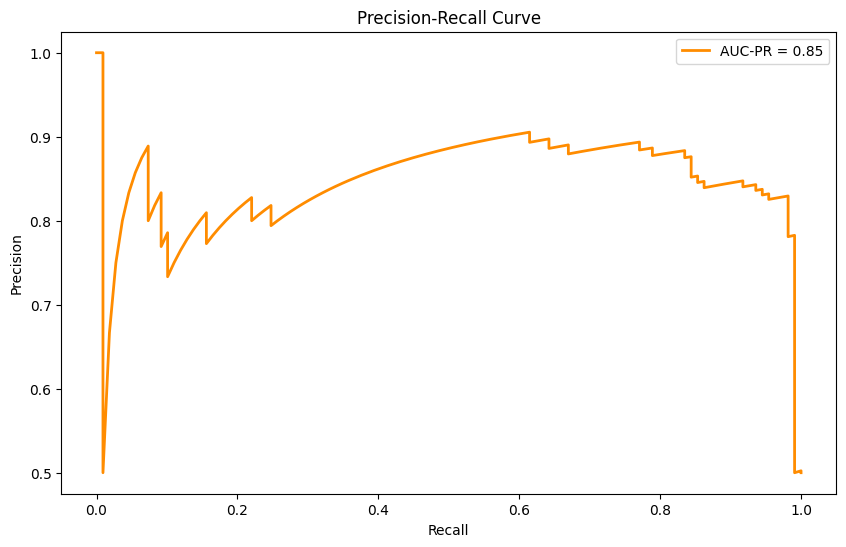

In [92]:
precision, recall, _ = precision_recall_curve(artificial_labels, validation_losses)

# Calculate the area under the precision-recall curve (AUC-PR)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


## TESTING ON DATA ##

In [110]:
model.eval()
validation_losses = []
y_label = []
iterator = 0
with torch.no_grad():
    for batch in test_loader:

        x_val = batch.to(device)
        x_val = x_val.view(-1, input_size)
        reconstruction_val, mu_val, log_var_val = model(x_val)
        validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
        validation_losses.append(validation_loss.item())
        y_label.append(y_test[iterator*8])
        iterator+=1



y_pred = (validation_losses  < optimal_threshold).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)

# Accuracy
accuracy = accuracy_score(y_label, y_pred)

# Precision
precision = precision_score(y_label, y_pred)

# Recall
recall = recall_score(y_label, y_pred)

# F1 Score
f1 = f1_score(y_label, y_pred)

# Matthews correlation coefficient
mcc = matthews_corrcoef(y_label, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)


Confusion Matrix:
[[65  2]
 [14 53]]
Accuracy: 0.8805970149253731
Precision: 0.9636363636363636
Recall: 0.7910447761194029
F1 Score: 0.8688524590163933
Matthews Correlation Coefficient: 0.7737047902246507


In [111]:
model.eval()
validation_losses = []
with torch.no_grad():
    for batch in test_loader:
        x_val = batch.to(device)
        x_val = x_val.view(-1, input_size)
        reconstruction_val, mu_val, log_var_val = model(x_val)
        validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
        validation_losses.append(validation_loss.item())
        




y_pred = (validation_losses  < optimal_threshold_ROC).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)

# Accuracy
accuracy = accuracy_score(y_label, y_pred)

# Precision
precision = precision_score(y_label, y_pred)

# Recall
recall = recall_score(y_label, y_pred)

# F1 Score
f1 = f1_score(y_label, y_pred)

# Matthews correlation coefficient
mcc = matthews_corrcoef(y_label, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient:", mcc)


Confusion Matrix:
[[59  8]
 [ 8 59]]
Accuracy: 0.8805970149253731
Precision: 0.8805970149253731
Recall: 0.8805970149253731
F1 Score: 0.8805970149253731
Matthews Correlation Coefficient: 0.7611940298507462
